# Edge detection algorithms comparison 

In [1]:
import typing as tp
from os.path import join
from os import listdir
from functools import partial

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
sns.set_context('notebook', rc={"lines.linewidth": 1})

## Define necessary functions

In [2]:
def read_img(folder: str) -> tp.Tuple[tp.Iterable[tp.Any]]:
    cvtcolor = lambda x, y: cv2.cvtColor(x, y)
    jpegs = filter(lambda x: x.endswith('jpg'), 
                   listdir(folder))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for img in jpegs:
        i = plt.imread(join(folder,img))
        i = cvtcolor(i, cv2.COLOR_RGB2HLS)
        i[:, :, 1] = clahe.apply(i[:, :, 1])
        yield cvtcolor(i, cv2.COLOR_HLS2RGB), i[:, :, 1], img

def compute_custom_gradient(img: np.ndarray, 
                     filter_x: np.ndarray,
                     filter_y: np.ndarray) -> np.ndarray:
    g_x, g_y = cv2.filter2D(img,-1,filter_x), cv2.filter2D(img,-1,filter_y)
    return np.sqrt(g_x.astype(np.float32)**2+g_y.astype(np.float32)**2)

def cannyf(img: np.ndarray, val: float, ratio: float, kernel_size: float) -> np.ndarray:
    low_threshold = val
    img_blur = cv2.blur(img, (5,5))
    detected_edges = cv2.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)
    mask = detected_edges != 0
    dst = img * np.reshape(mask[:,:,None],img.shape)
    return dst.reshape(img.shape)
    
def laplacian(img: np.ndarray, depth: float, kernel_size: float) -> np.ndarray:
    return cv2.Laplacian(img, depth, kernel_size)

def compute_builtin_gradient(img: np.ndarray, 
                             method: tp.Callable[[tp.Iterable[tp.Any]], np.ndarray], 
                             **kwargs) -> np.ndarray:
    return method(img, **kwargs)

## Define kernels 

In [3]:
roberts = np.array([[1., 0], [0., -1]]), np.array([[0., 1.], [-1., 0]])
sobel = np.array([[-1., -2., -1.], [0., 0., 0.], [1., 1., 1.]]).T, np.array([[-1., -2., -1.], [0., 0., 0.], [1., 1., 1.]])
prewitt = np.array([[-1., 0., 1.], [-1., 0., 1.], [-1., 0., 1.]]), np.array([[-1., -1., -1.], [0., 0., 0.], [1., 1., 1.]])
canny = {'val': 10, 'ratio': 10, 'kernel_size': 3}
laplace = {'depth': 10, 'kernel_size': 3}

algs = dict(name=['roberts', 'sobel', 'prewitt', 'canny', 'laplace'],
           funcs=[partial(compute_custom_gradient, filter_x=gx, filter_y=gy) for (gx, gy) in [roberts, sobel, prewitt]]+\
                 [partial(compute_builtin_gradient, method=cannyf, **canny), 
                 partial(compute_builtin_gradient, method=laplacian, **laplace)])

## Applying algorithms to every image

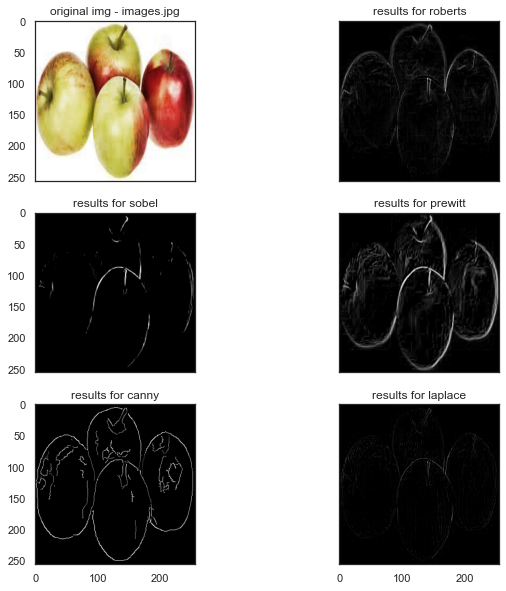

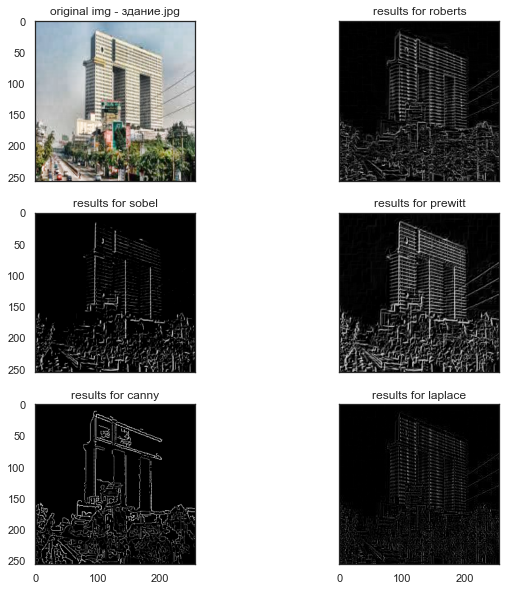

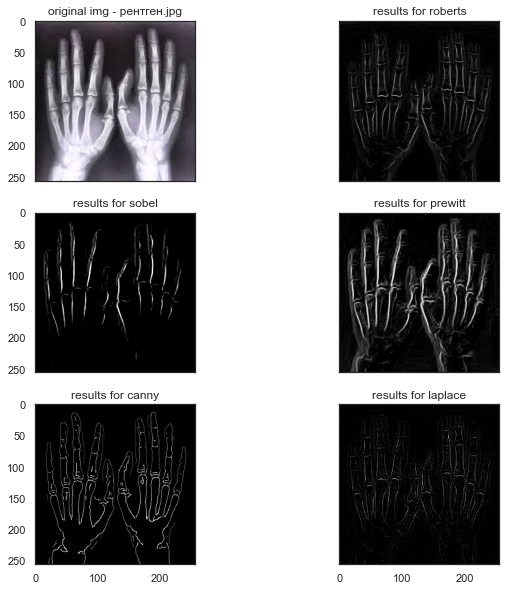

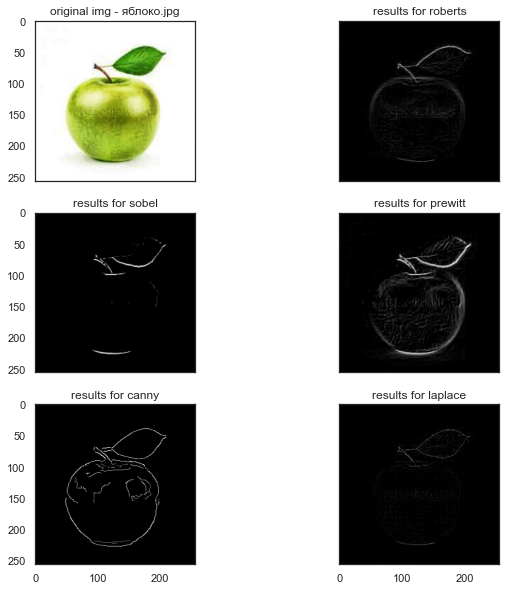

In [4]:
for img, img_gray, path in read_img('1'):
    rgb_img = cv2.resize(img,(256,256))
    gray_img = cv2.resize(img_gray,(256,256))
    with sns.axes_style("white"):
    # looping every cluster     
        f, ax = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)
        with sns.axes_style("white"):
            ax[0][0].imshow(rgb_img)
            ax[0][0].set_title(f'original img - {path}')
            ax[0][0].grid(False)
            for i, (algn, alg) in tqdm(enumerate(zip(algs['name'], algs['funcs'])), 
                               desc=f'Processing edge detection for {path}',
                               ncols=10,
                               dynamic_ncols=True, unit='iter'):
                ax[(i+1)//2][(i+1)%2].imshow(alg(gray_img), 'gray')
                ax[(i+1)//2][(i+1)%2].set_title(f'results for {algn}')
                ax[(i+1)//2][(i+1)%2].grid(False)
        plt.show()

# Conclusion
### As seen above, the best one is Canny edge detector, because it is the most sophicticated, compared to every other algorithm, mentioned in this assignment. Due to "two-step" detection technique - smoothing (convolution with gaussian kernel) + sum-convolution we have achieved such outstanding results